In [60]:
%matplotlib widget
from math import pi
import numpy as np
import matplotlib.pyplot as plt
import openmc
import openmc.model

fuel = openmc.Material(name='Fuel')
fuel.set_density('g/cm3', 10.5)
fuel.add_nuclide('U235', 4.6716e-02)
fuel.add_nuclide('U238', 2.8697e-01)
fuel.add_nuclide('O16',  5.0000e-01)
fuel.add_element('C', 1.6667e-01)

buff = openmc.Material(name='Buffer')
buff.set_density('g/cm3', 1.0)
buff.add_element('C', 1.0)
buff.add_s_alpha_beta('c_Graphite')

PyC1 = openmc.Material(name='PyC1')
PyC1.set_density('g/cm3', 1.9)
PyC1.add_element('C', 1.0)
PyC1.add_s_alpha_beta('c_Graphite')

PyC2 = openmc.Material(name='PyC2')
PyC2.set_density('g/cm3', 1.87)
PyC2.add_element('C', 1.0)
PyC2.add_s_alpha_beta('c_Graphite')

SiC = openmc.Material(name='SiC')
SiC.set_density('g/cm3', 3.2)
SiC.add_element('C', 0.5)
SiC.add_element('Si', 0.5)

graphite = openmc.Material()
graphite.set_density('g/cm3', 1.1995)
graphite.add_element('C', 1.0)
graphite.add_s_alpha_beta('c_Graphite')

In [61]:
# Create TRISO universe

spheres = [openmc.Sphere(r=1e-4*r)
           for r in [215., 315., 350., 385.]]
cells = [openmc.Cell(fill=fuel, region=-spheres[0]),
         openmc.Cell(fill=buff, region=+spheres[0] & -spheres[1]),
         openmc.Cell(fill=PyC1, region=+spheres[1] & -spheres[2]),
         openmc.Cell(fill=SiC, region=+spheres[2] & -spheres[3]),
         openmc.Cell(fill=PyC2, region=+spheres[3])]

triso_univ = openmc.Universe(cells=cells)


In [62]:
'''
min_x = openmc.XPlane(x0=-0.5, boundary_type='reflective')
max_x = openmc.XPlane(x0=0.5, boundary_type='reflective')
min_y = openmc.YPlane(y0=-0.5, boundary_type='reflective')
max_y = openmc.YPlane(y0=0.5, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-0.5, boundary_type='reflective')
max_z = openmc.ZPlane(z0=0.5, boundary_type='reflective')
region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z
'''

radius = 0.5                
height = 1.0             

outer_cyl = openmc.ZCylinder(r=radius, boundary_type='reflective')
bottom    = openmc.ZPlane(z0=-height/2, boundary_type='reflective')
top       = openmc.ZPlane(z0=+height/2, boundary_type='reflective')

region = -outer_cyl & +bottom & -top


In [63]:
outer_radius = 425.*1e-4
centers = openmc.model.pack_spheres(radius=outer_radius, region=region, pf=0.3, seed=124848351)

In [64]:
trisos = [openmc.model.TRISO(outer_radius, triso_univ, center) for center in centers]

In [65]:
centers = np.vstack([triso.center for triso in trisos])
print(centers.min(axis=0))
print(centers.max(axis=0))

[-0.45479864 -0.4464904  -0.45741001]
[0.45424123 0.45309096 0.45646179]


In [66]:
box = openmc.Cell(region=region)
lower_left, upper_right = box.region.bounding_box
shape = (3, 3, 3)
pitch = (upper_right - lower_left)/shape
lattice = openmc.model.create_triso_lattice(
    trisos, lower_left, pitch, shape, graphite)

In [67]:
box.fill = lattice

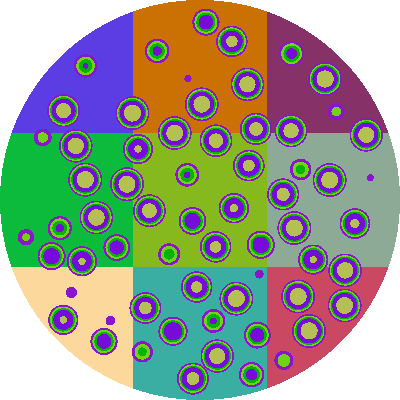

In [68]:
universe = openmc.Universe(cells=[box])

geometry = openmc.Geometry(universe)
geometry.export_to_xml()

materials = list(geometry.get_all_materials().values())
openmc.Materials(materials).export_to_xml()

settings = openmc.Settings()
settings.run_mode = 'plot'
settings.export_to_xml()

plot = openmc.Plot.from_geometry(geometry)
plot.to_ipython_image()

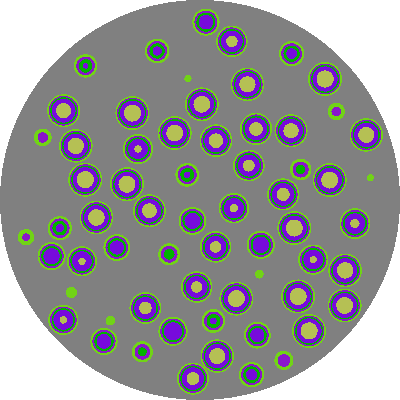

In [69]:
plot.color_by = 'material'
plot.colors = {graphite: 'gray'}
plot.to_ipython_image()

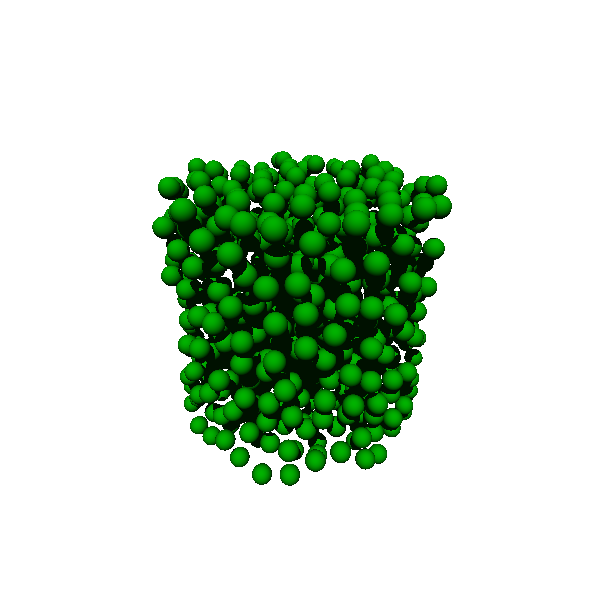

In [70]:
plot = openmc.SolidRayTracePlot()
plot.pixels = (600, 600)
#plot.camera_position = (10.0, 20.0, -30.0)
norm = np.sqrt(10**2 + 20**2 + 30**2)
plot.camera_position = (20.0/norm, 50.0/norm, 30.0/norm)
plot.look_at = (0, 0, 0)
plot.color_by = 'cell'

plot.light_position = (10, 20, 30)

plot.diffuse_fraction = 0.1
plot.opaque_domains = [cells[1], cells[2]]
openmc.plot_inline(plot)

In [71]:
vox = openmc.Plot()
vox.type       = 'voxel'
vox.filename   = 'geom'
vox.width      = (1.0, 1.0, 1.0)
vox.pixels     = (400, 400, 400)
vox.color_by   = 'material'
openmc.plot_geometry(vox)

openmc.voxel_to_vtk('geom.h5', 'geom.vti')


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'geom.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [74]:
!ls pebbletest/depletion_results.h5

pebbletest/depletion_results.h5


[<StepResult: t=0.0, dt=2592000.0, source=250.0>, <StepResult: t=2592000.0, dt=2592000.0, source=250.0>, <StepResult: t=5184000.0, dt=2592000.0, source=250.0>, <StepResult: t=7776000.0, dt=0.0, source=250.0>]
[[1.06977192 0.00307456]
 [1.07273086 0.00304489]
 [1.06739069 0.00242043]
 [1.06585621 0.00280256]]


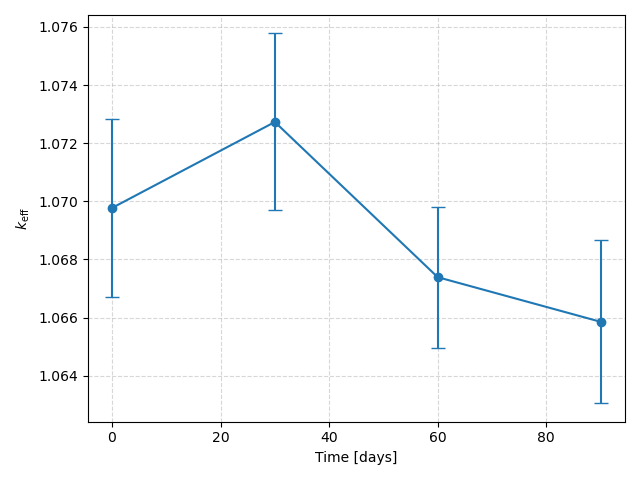

In [2]:
%matplotlib widget
import openmc.deplete as dep
import matplotlib.pyplot as plt
plt.clf()
res = dep.Results("pebbletest/depletion_results.h5")
print(res)
time, keff = res.get_keff()
print(keff)
keff_mean = keff[:, 0]
keff_std  = keff[:, 1]
time = time/8.64e4
plt.errorbar(time, keff_mean, yerr=keff_std, fmt='o-', capsize=5)
#plt.xlabel('Depletion Step')
plt.ylabel(r'$k_\text{eff}$')
plt.xlabel('Time [days]')
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

[<StepResult: t=0.0, dt=2592000.0, source=250.0>, <StepResult: t=2592000.0, dt=2592000.0, source=250.0>, <StepResult: t=5184000.0, dt=2592000.0, source=250.0>, <StepResult: t=7776000.0, dt=0.0, source=250.0>]


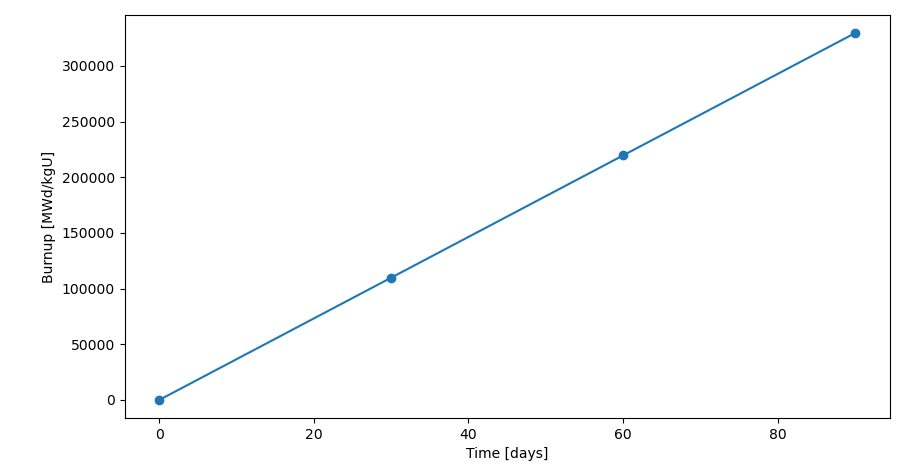

In [19]:
%matplotlib widget
import openmc.deplete as dep
import matplotlib.pyplot as plt
plt.clf()
res = dep.Results("pebbletest/depletion_results.h5")
print(res)
time, mass235 = res.get_mass('1', 'U235')
time, mass238 = res.get_mass('1', 'U238')
time, mass16 = res.get_mass('1', 'O16')
Mtot = mass235 + mass238 + mass16
burnup = lambda t: 250* t / Mtot  # in MWd/kgU
plt.plot(time/8.64e4, burnup(time), 'o-')
plt.xlabel('Time [days]')
plt.ylabel('Burnup [MWd/kgU]')
plt.show()